In [85]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import torch
device = 'cpu'
from torchdiffeq import odeint

In [96]:
def FN_torch(t, V, a=0.2, b=0.2, c=3.0):
    return torch.hstack((c * (V[0] - V[0]**3/3 + V[1]), -1/c * (V[0] - a + b*V[1])))

def FN_torch_modified(t, V, eta, a=0.2, b=0.2, c=3.0):
    V1 = c * (V[0] - V[0]**3/3 + V[1])
    V2 = -1/c * (V[0] - a + b*V[1])
    dV = torch.hstack((V1, V2))
    terms = torch.tensor([V[0]**2, V[1]**2])
    dV += torch.matmul(eta, terms)
    return dV

def FN_torch_modified_large(t, V, eta, a=0.2, b=0.2, c=3.0):
    V1 = c * (V[0] - V[0]**3/3 + V[1])
    V2 = -1/c * (V[0] - a + b*V[1])
    dV = torch.hstack((V1, V2))
    terms = torch.tensor([V[0]**2, V[1]**2, V[0]*V[1], V[0]**2*V[1], V[0]*V[1]**2, torch.exp(V[0]), torch.exp(V[1]), V[0]**4, V[0]**3*V[1], V[0]**2*V[1]**2, V[0]*V[1]**3, V[1]**4])
    dV += torch.matmul(eta, terms)
    return dV 

In [87]:
class DiffLoss(torch.nn.Module):
    
    def __init__(self):
        super(DiffLoss, self).__init__()
        
    def forward(self, a, b):
        
        a_diff = torch.diff(a, axis=0)
        b_diff = torch.diff(b, axis=0)
        
        return torch.mean((a_diff - b_diff)**2)

In [88]:
class OptimizeFitzhugh(torch.nn.Module):
    
    def __init__(self, x0, t_space, n_terms, eta0):
        super(OptimizeFitzhugh, self).__init__()
        self.x0 = x0
        self.t_space = t_space
        self.n_terms = n_terms
        self.eta = eta0
        self.eta.requires_grad_()
        
    def rhs(self, x, t):
        return FN_torch_modified(t, x, self.eta)
    
    def forward(self, t, x):
        return self.rhs(x, t)

In [176]:
class OptimizeFitzhughLarge(torch.nn.Module):
    
    def __init__(self, x0, t_space, n_terms, eta0):
        super(OptimizeFitzhughLarge, self).__init__()
        self.x0 = x0
        self.t_space = t_space
        self.n_terms = n_terms
        self.eta = eta0
        self.eta.requires_grad_()
        
    def rhs(self, x, t):
        return FN_torch_modified_large(t, x, self.eta)
    
    def forward(self, t, x):
        return self.rhs(x, t)

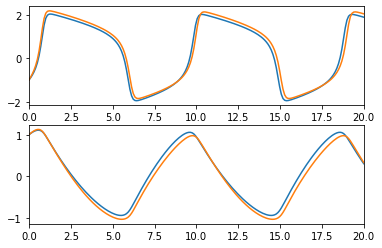

In [12]:
true_eta = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float)

fn_true = lambda t, x : FN_torch_modified(t, x, true_eta)

N = 200
ub = 20

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
soln = odeint(fn_true, x0, t_space)

soln_unpert = odeint(FN_torch, x0, t_space)

ax1 = plt.subplot(211)
ax1.set_xlim(0,ub)
plt.plot(t_space, soln_unpert[:,0])
plt.plot(t_space, soln[:,0])

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(t_space, soln_unpert[:,1])
plt.plot(t_space, soln[:,1])
plt.show()

In [22]:
eta_method = 'random'
check_grads = False
max_it = 100

N = 200
ub = 20

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
x0.requires_grad_()
tol = 10**-5


if eta_method == 'random':
    eta0 = torch.tensor(np.random.normal(0, 0.001, (2,2)), dtype=torch.float).to(device)
elif eta_method == 'zeros':
    eta0 = torch.tensor(np.zeros((2,2)), dtype=torch.float).to(device)
elif eta_method == 'actual':
    eta0 = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float).to(device)
else:
    raise ValueError('You are trying to set eta in a way that is not supported. Check eta_method.')

print(eta0)

with torch.no_grad():
    true_eta = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float)
    true_FN = lambda t, x : FN_torch_modified(t, x, true_eta)
    true_soln = odeint(true_FN, x0, t_space)


optfitz = OptimizeFitzhugh(x0, t_space, 2, eta0).to(device)


optimizer = torch.optim.Adam([optfitz.eta], lr=10**-3)
loss = DiffLoss().to(device)

print('eta_0 = \n{}\n'.format(optfitz.eta.detach().numpy()))

loss_vec = []
eta_log = []

np.set_printoptions(precision=4)
for it in range(max_it):

    optimizer.zero_grad()

    pred_soln = odeint(optfitz, x0, t_space).to(device)

    loss_curr = loss(pred_soln, true_soln)
    loss_curr.retain_grad()
    loss_curr.backward()

    if check_grads:
        if it > 0:
            for i in range(optfitz.eta.shape[0]):
                for j in range(optfitz.eta.shape[1]):
                    print('Backprop Derivative for {},{} = {:.2f}'.format(i, j, optfitz.eta.grad[i,j]))
                    print('Checked Derivative for {},{} = {:.2f}'.format(i, j, grad_check[i,j]))
                    # print('Error Ratio = {:.2f}'.format(optfitz.eta.grad[i,j] / grad_check[i,j]))
                    print()
        print('\n')

    print('Iterarion {}'.format(it+1))
    print('eta = \n{}'.format(optfitz.eta.detach().numpy()))
    eta_log.append(optfitz.eta.detach().numpy())
    print('loss = {:.4f}\n\n'.format(loss_curr))

    if np.linalg.norm(optfitz.eta.grad.detach().numpy()) < tol:
        if not (eta_method == 'actual' and it < 1):
            break

    loss_vec.append(loss_curr.detach().numpy())

    if check_grads:

        print('===Derivative Check===')

        grad_check = np.zeros((optfitz.eta.shape[0], optfitz.eta.shape[1]))
        for i in range(optfitz.eta.shape[0]):
            for j in range(optfitz.eta.shape[1]):
                eps = 10**(-3)
                eta_check_0 = optfitz.eta.detach().clone()
                eta_check_1 = optfitz.eta.detach().clone()

                eta_check_0[i,j] += eps
                eta_check_1[i,j] -= eps

                FN_check_0 = lambda t, S : FN_torch_modified(t, S, eta_check_0)
                x_pred_check_0 = odeint(FN_check_0, x0, t_space)
                FN_check_1 = lambda t, S : FN_torch_modified(t, S, eta_check_1)
                x_pred_check_1 = odeint(FN_check_1, x0, t_space)

                L0 = loss(x_pred_check_0, true_soln)
                L1 = loss(x_pred_check_1, true_soln)
                grad_check[i,j] = ((L0 - L1)/(2*eps)).item()

    optimizer.step()


tensor([[1.5741e-04, 7.7013e-05],
        [5.2232e-04, 1.4168e-03]])
eta_0 = 
[[1.5741e-04 7.7013e-05]
 [5.2232e-04 1.4168e-03]]

Iterarion 1
eta = 
[[1.5741e-04 7.7013e-05]
 [5.2232e-04 1.4168e-03]]
loss = 0.0016


Iterarion 2
eta = 
[[-0.0008  0.0011]
 [ 0.0015  0.0024]]
loss = 0.0012


Iterarion 3
eta = 
[[-0.0018  0.002 ]
 [ 0.0025  0.0034]]
loss = 0.0008


Iterarion 4
eta = 
[[-0.0028  0.0029]
 [ 0.0035  0.0044]]
loss = 0.0006


Iterarion 5
eta = 
[[-0.0036  0.0034]
 [ 0.0044  0.0053]]
loss = 0.0005


Iterarion 6
eta = 
[[-0.0043  0.0035]
 [ 0.0052  0.006 ]]
loss = 0.0005


Iterarion 7
eta = 
[[-0.0046  0.0032]
 [ 0.0058  0.0066]]
loss = 0.0006


Iterarion 8
eta = 
[[-0.0047  0.0027]
 [ 0.0063  0.007 ]]
loss = 0.0006


Iterarion 9
eta = 
[[-0.0045  0.0021]
 [ 0.0065  0.0072]]
loss = 0.0007


Iterarion 10
eta = 
[[-0.0042  0.0013]
 [ 0.0066  0.0072]]
loss = 0.0007


Iterarion 11
eta = 
[[-0.0037  0.0005]
 [ 0.0065  0.007 ]]
loss = 0.0007


Iterarion 12
eta = 
[[-0.0031 -0.0003]
 [ 

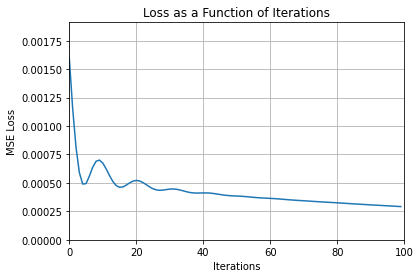

In [23]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(loss_vec)), loss_vec)
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Loss as a Function of Iterations')
ax.set_xlim((0, max_it))
ax.set_ylim((0, max(loss_vec) * 1.2))
plt.grid()
plt.show()

eta = 
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0005, 0.0000, 0.0500, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]])


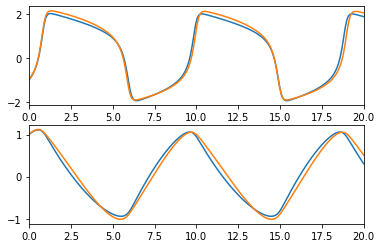

In [171]:
n_basis = 12

true_eta = torch.zeros((2,n_basis), dtype=torch.float)
non_zero = np.random.choice(range(2*n_basis), 3, replace=False)
for ix in non_zero:
    i = int(ix/n_basis)
    j = int(ix)%n_basis
    if j == 5 or j == 6:
        true_eta[i,j] += 0.0005
    else:
        true_eta[i,j] += 0.05
    
# true_eta = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0.05,0], [0,0.05,0,0,0,0.005,0,0,0,0,0,0]], dtype=torch.float)

print('eta = \n{}'.format(true_eta))

fn_true = lambda t, x : FN_torch_modified_large(t, x, true_eta)

N = 200
ub = 20

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
soln = odeint(fn_true, x0, t_space)

soln_unpert = odeint(FN_torch, x0, t_space)

ax1 = plt.subplot(211)
ax1.set_xlim(0,ub)
plt.plot(t_space, soln_unpert[:,0])
plt.plot(t_space, soln[:,0])

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(t_space, soln_unpert[:,1])
plt.plot(t_space, soln[:,1])
plt.show()

In [178]:
eta_method = 'random'
check_grads = False
max_it = 1000

N = 200
ub = 20
n_basis = 12

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
x0.requires_grad_()
tol = 10**-5

true_eta = torch.zeros((2,n_basis), dtype=torch.float)
non_zero = np.random.choice(range(2*n_basis), 3, replace=False)
for ix in non_zero:
    i = int(ix/n_basis)
    j = int(ix)%n_basis
    if j == 5 or j == 6:
        true_eta[i,j] += 0.0005
    else:
        true_eta[i,j] += 0.05


if eta_method == 'random':
    eta0 = torch.tensor(np.random.normal(0, 0.001, (2, n_basis)), dtype=torch.float).to(device)
elif eta_method == 'zeros':
    eta0 = torch.tensor(np.zeros((2, n_basis)), dtype=torch.float).to(device)
elif eta_method == 'actual':
    eta0 = true_eta.copy_()
else:
    raise ValueError('You are trying to set eta in a way that is not supported. Check eta_method.')

# print(eta0)

with torch.no_grad():
    true_FN = lambda t, x : FN_torch_modified_large(t, x, true_eta)
    true_soln = odeint(true_FN, x0, t_space)


optfitz = OptimizeFitzhughLarge(x0, t_space, n_basis, eta0).to(device)


optimizer = torch.optim.Adam([optfitz.eta], lr=10**-3)
loss = DiffLoss().to(device)

print('eta_0 = \n{}\n'.format(optfitz.eta.detach().numpy()))

loss_vec = []
eta_log = []

np.set_printoptions(precision=4)
for it in range(max_it):

    optimizer.zero_grad()

    pred_soln = odeint(optfitz, x0, t_space).to(device)

    loss_curr = loss(pred_soln, true_soln)
    loss_curr.retain_grad()
    loss_curr.backward()

    if check_grads:
        if it > 0:
            for i in range(optfitz.eta.shape[0]):
                for j in range(optfitz.eta.shape[1]):
                    print('Backprop Derivative for {},{} = {:.2f}'.format(i, j, optfitz.eta.grad[i,j]))
                    print('Checked Derivative for {},{} = {:.2f}'.format(i, j, grad_check[i,j]))
                    # print('Error Ratio = {:.2f}'.format(optfitz.eta.grad[i,j] / grad_check[i,j]))
                    print()
        print('\n')

    print('Iterarion {}'.format(it+1))
    print('eta = \n{}'.format(optfitz.eta.detach().numpy()))
    eta_log.append(optfitz.eta.detach().numpy())
    print('loss = {:.4f}\n\n'.format(loss_curr))

    if np.linalg.norm(optfitz.eta.grad.detach().numpy()) < tol:
        if not (eta_method == 'actual' and it < 1):
            break

    loss_vec.append(loss_curr.detach().numpy())

    if check_grads:

        print('===Derivative Check===')

        grad_check = np.zeros((optfitz.eta.shape[0], optfitz.eta.shape[1]))
        for i in range(optfitz.eta.shape[0]):
            for j in range(optfitz.eta.shape[1]):
                eps = 10**(-3)
                eta_check_0 = optfitz.eta.detach().clone()
                eta_check_1 = optfitz.eta.detach().clone()

                eta_check_0[i,j] += eps
                eta_check_1[i,j] -= eps

                FN_check_0 = lambda t, S : FN_torch_modified_large(t, S, eta_check_0)
                x_pred_check_0 = odeint(FN_check_0, x0, t_space)
                FN_check_1 = lambda t, S : FN_torch_modified_large(t, S, eta_check_1)
                x_pred_check_1 = odeint(FN_check_1, x0, t_space)

                L0 = loss(x_pred_check_0, true_soln)
                L1 = loss(x_pred_check_1, true_soln)
                grad_check[i,j] = ((L0 - L1)/(2*eps)).item()

    optimizer.step()


eta_0 = 
[[-1.2677e-03 -4.9448e-04  1.5100e-04 -5.2756e-04 -6.6698e-04 -5.6597e-06
  -8.1162e-04 -1.7179e-03 -2.9632e-04  2.7735e-04 -1.2517e-03 -2.1259e-03]
 [-2.6574e-04 -8.2947e-04  5.3410e-04 -1.2134e-03  3.5851e-04  4.0046e-04
   1.7787e-03 -8.8707e-04  1.1437e-03  6.8596e-04  4.1813e-04 -3.6687e-04]]

Iterarion 1
eta = 
[[-1.2677e-03 -4.9448e-04  1.5100e-04 -5.2756e-04 -6.6698e-04 -5.6597e-06
  -8.1162e-04 -1.7179e-03 -2.9632e-04  2.7735e-04 -1.2517e-03 -2.1259e-03]
 [-2.6574e-04 -8.2947e-04  5.3410e-04 -1.2134e-03  3.5851e-04  4.0046e-04
   1.7787e-03 -8.8707e-04  1.1437e-03  6.8596e-04  4.1813e-04 -3.6687e-04]]
loss = 0.0106


Iterarion 2
eta = 
[[-0.0023  0.0005 -0.0008 -0.0015  0.0003  0.001  -0.0018 -0.0027 -0.0013
   0.0013 -0.0023 -0.0031]
 [ 0.0007  0.0002 -0.0005 -0.0022  0.0014  0.0014  0.0028  0.0001  0.0021
   0.0017  0.0014  0.0006]]
loss = 0.0058


Iterarion 3
eta = 
[[-0.0032  0.0013 -0.0018 -0.0025  0.0013  0.002  -0.0028 -0.0037 -0.0023
   0.0023 -0.0032 -0.0041]

Iterarion 34
eta = 
[[-0.0017  0.0052 -0.0024 -0.003   0.0013  0.0027 -0.0031 -0.0031 -0.0034
   0.0182 -0.0046 -0.0023]
 [ 0.0016  0.0017 -0.0016 -0.0026  0.0027  0.0026  0.0039  0.001   0.0029
   0.0027 -0.0003  0.0025]]
loss = 0.0002


Iterarion 35
eta = 
[[-0.0018  0.0055 -0.0025 -0.0031  0.0013  0.0028 -0.0031 -0.0032 -0.0035
   0.0188 -0.0047 -0.0022]
 [ 0.0017  0.0018 -0.0017 -0.0027  0.0028  0.0027  0.004   0.0011  0.0029
   0.0028 -0.0004  0.0026]]
loss = 0.0001


Iterarion 36
eta = 
[[-0.0019  0.0059 -0.0026 -0.0032  0.0014  0.0029 -0.0032 -0.0033 -0.0036
   0.0195 -0.0048 -0.0021]
 [ 0.0018  0.0019 -0.0019 -0.0027  0.0029  0.0028  0.0041  0.0012  0.003
   0.0029 -0.0004  0.0028]]
loss = 0.0001


Iterarion 37
eta = 
[[-0.0019  0.0062 -0.0027 -0.0032  0.0015  0.0029 -0.0032 -0.0034 -0.0037
   0.0201 -0.005  -0.002 ]
 [ 0.0019  0.002  -0.002  -0.0027  0.003   0.0029  0.0043  0.0013  0.0031
   0.0029 -0.0005  0.0029]]
loss = 0.0001


Iterarion 38
eta = 
[[-0.0019  0.0065 -0.0028

Iterarion 67
eta = 
[[-0.0007  0.0104 -0.0029 -0.0028  0.001   0.0028 -0.0025 -0.0029 -0.0043
   0.0325 -0.0051  0.0005]
 [ 0.0018  0.0023 -0.0011 -0.0005  0.0028  0.0027  0.0044  0.0012  0.0037
   0.003   0.001   0.0034]]
loss = 0.0000


Iterarion 68
eta = 
[[-0.0006  0.0105 -0.0029 -0.0027  0.001   0.0028 -0.0025 -0.0028 -0.0043
   0.0328 -0.0051  0.0005]
 [ 0.0018  0.0023 -0.001  -0.0005  0.0028  0.0027  0.0044  0.0012  0.0037
   0.003   0.0011  0.0034]]
loss = 0.0000


Iterarion 69
eta = 
[[-0.0006  0.0105 -0.0029 -0.0027  0.0009  0.0028 -0.0025 -0.0028 -0.0043
   0.0331 -0.005   0.0006]
 [ 0.0018  0.0023 -0.0009 -0.0004  0.0028  0.0027  0.0044  0.0012  0.0037
   0.003   0.0012  0.0034]]
loss = 0.0000


Iterarion 70
eta = 
[[-0.0005  0.0106 -0.0029 -0.0027  0.0009  0.0027 -0.0024 -0.0028 -0.0043
   0.0334 -0.005   0.0007]
 [ 0.0018  0.0023 -0.0009 -0.0003  0.0028  0.0027  0.0044  0.0012  0.0037
   0.003   0.0013  0.0034]]
loss = 0.0000


Iterarion 71
eta = 
[[-0.0004  0.0107 -0.002

Iterarion 96
eta = 
[[ 4.3818e-04  1.3108e-02 -2.6905e-03 -2.1929e-03  5.2202e-04  2.4166e-03
  -1.8388e-03 -2.3901e-03 -4.5971e-03  4.0712e-02 -4.3156e-03  2.0313e-03]
 [ 1.7399e-03  2.6313e-03  6.2532e-05  1.6004e-03  2.6825e-03  2.5279e-03
   4.5494e-03  1.1791e-03  4.4204e-03  3.0782e-03  3.4421e-03  3.9819e-03]]
loss = 0.0000


Iterarion 97
eta = 
[[ 4.7199e-04  1.3189e-02 -2.6744e-03 -2.1708e-03  5.0389e-04  2.3978e-03
  -1.8144e-03 -2.3743e-03 -4.5994e-03  4.0933e-02 -4.2752e-03  2.0786e-03]
 [ 1.7376e-03  2.6436e-03  9.6835e-05  1.6727e-03  2.6757e-03  2.5205e-03
   4.5561e-03  1.1774e-03  4.4447e-03  3.0816e-03  3.5140e-03  4.0031e-03]]
loss = 0.0000


Iterarion 98
eta = 
[[ 0.0005  0.0133 -0.0027 -0.0022  0.0005  0.0024 -0.0018 -0.0024 -0.0046
   0.0412 -0.0042  0.0021]
 [ 0.0017  0.0027  0.0001  0.0017  0.0027  0.0025  0.0046  0.0012  0.0045
   0.0031  0.0036  0.004 ]]
loss = 0.0000


Iterarion 99
eta = 
[[ 0.0005  0.0134 -0.0027 -0.0021  0.0005  0.0024 -0.0018 -0.0024 -0.00

Iterarion 129
eta = 
[[ 1.3911e-03  1.5204e-02 -1.9555e-03 -1.5538e-03  2.6994e-05  1.8393e-03
  -1.1680e-03 -1.9373e-03 -4.4775e-03  4.6102e-02 -2.6154e-03  3.1848e-03]
 [ 1.7140e-03  3.1126e-03  1.0891e-03  3.7576e-03  2.5287e-03  2.3453e-03
   4.8248e-03  1.1698e-03  5.2559e-03  3.2514e-03  5.7678e-03  4.7628e-03]]
loss = 0.0000


Iterarion 130
eta = 
[[ 1.4150e-03  1.5254e-02 -1.9266e-03 -1.5360e-03  1.3886e-05  1.8216e-03
  -1.1504e-03 -1.9253e-03 -4.4672e-03  4.6208e-02 -2.5533e-03  3.2120e-03]
 [ 1.7141e-03  3.1292e-03  1.1157e-03  3.8158e-03  2.5250e-03  2.3408e-03
   4.8346e-03  1.1702e-03  5.2804e-03  3.2578e-03  5.8288e-03  4.7885e-03]]
loss = 0.0000


Iterarion 131
eta = 
[[ 1.4390e-03  1.5303e-02 -1.8969e-03 -1.5179e-03  4.4412e-07  1.8035e-03
  -1.1324e-03 -1.9130e-03 -4.4560e-03  4.6308e-02 -2.4900e-03  3.2389e-03]
 [ 1.7139e-03  3.1454e-03  1.1423e-03  3.8734e-03  2.5210e-03  2.3359e-03
   4.8440e-03  1.1703e-03  5.3044e-03  3.2637e-03  5.8886e-03  4.8139e-03]]
loss = 0

Iterarion 160
eta = 
[[ 0.0021  0.0164 -0.0009 -0.001  -0.0004  0.0013 -0.0006 -0.0016 -0.0039
   0.0479 -0.0004  0.0039]
 [ 0.0017  0.0036  0.0018  0.0053  0.0024  0.0022  0.0051  0.0011  0.0059
   0.0034  0.0073  0.0055]]
loss = 0.0000


Iterarion 161
eta = 
[[ 0.0021  0.0165 -0.0008 -0.001  -0.0004  0.0012 -0.0006 -0.0015 -0.0039
   0.048  -0.0003  0.0039]
 [ 0.0017  0.0036  0.0019  0.0054  0.0024  0.0022  0.0051  0.0011  0.0059
   0.0034  0.0074  0.0056]]
loss = 0.0000


Iterarion 162
eta = 
[[ 0.0021  0.0165 -0.0008 -0.001  -0.0004  0.0012 -0.0006 -0.0015 -0.0039
   0.048  -0.0002  0.0039]
 [ 0.0017  0.0036  0.0019  0.0054  0.0024  0.0022  0.0051  0.0011  0.006
   0.0034  0.0074  0.0056]]
loss = 0.0000


Iterarion 163
eta = 
[[ 0.0021  0.0165 -0.0007 -0.001  -0.0004  0.0012 -0.0006 -0.0015 -0.0039
   0.048  -0.0002  0.004 ]
 [ 0.0017  0.0037  0.0019  0.0054  0.0024  0.0022  0.0051  0.0011  0.006
   0.0034  0.0075  0.0056]]
loss = 0.0000


Iterarion 164
eta = 
[[ 2.1445e-03  1.6575

Iterarion 191
eta = 
[[ 0.0026  0.0174  0.0005 -0.0005 -0.0007  0.0008 -0.0002 -0.0012 -0.0031
   0.0478  0.0022  0.0045]
 [ 0.0016  0.0041  0.0024  0.0064  0.0023  0.002   0.0054  0.0011  0.0065
   0.0036  0.0084  0.0064]]
loss = 0.0000


Iterarion 192
eta = 
[[ 0.0026  0.0174  0.0005 -0.0005 -0.0007  0.0007 -0.0002 -0.0012 -0.0031
   0.0478  0.0022  0.0045]
 [ 0.0016  0.0042  0.0024  0.0064  0.0023  0.002   0.0054  0.0011  0.0065
   0.0036  0.0085  0.0064]]
loss = 0.0000


Iterarion 193
eta = 
[[ 0.0026  0.0174  0.0006 -0.0005 -0.0007  0.0007 -0.0002 -0.0012 -0.0031
   0.0477  0.0023  0.0045]
 [ 0.0016  0.0042  0.0024  0.0065  0.0023  0.002   0.0054  0.0011  0.0065
   0.0036  0.0085  0.0064]]
loss = 0.0000


Iterarion 194
eta = 
[[ 0.0026  0.0175  0.0006 -0.0005 -0.0007  0.0007 -0.0002 -0.0012 -0.003
   0.0477  0.0024  0.0046]
 [ 0.0016  0.0042  0.0025  0.0065  0.0023  0.002   0.0054  0.0011  0.0065
   0.0036  0.0085  0.0064]]
loss = 0.0000


Iterarion 195
eta = 
[[ 0.0027  0.0175  0

Iterarion 219
eta = 
[[ 0.003   0.0181  0.0018 -0.0002 -0.0009  0.0004  0.0001 -0.0009 -0.0022
   0.0466  0.0046  0.0051]
 [ 0.0016  0.0046  0.0028  0.0071  0.0022  0.0019  0.0056  0.001   0.0069
   0.0037  0.0091  0.0071]]
loss = 0.0000


Iterarion 220
eta = 
[[ 0.003   0.0182  0.0019 -0.0002 -0.0009  0.0004  0.0001 -0.0009 -0.0022
   0.0466  0.0047  0.0051]
 [ 0.0016  0.0046  0.0028  0.0071  0.0022  0.0019  0.0056  0.001   0.0069
   0.0037  0.0091  0.0071]]
loss = 0.0000


Iterarion 221
eta = 
[[ 0.003   0.0182  0.0019 -0.0002 -0.0009  0.0004  0.0001 -0.0009 -0.0022
   0.0465  0.0048  0.0051]
 [ 0.0016  0.0047  0.0028  0.0071  0.0022  0.0019  0.0056  0.001   0.0069
   0.0037  0.0092  0.0072]]
loss = 0.0000


Iterarion 222
eta = 
[[ 0.003   0.0182  0.002  -0.0001 -0.0009  0.0003  0.0001 -0.0009 -0.0021
   0.0465  0.0049  0.0051]
 [ 0.0016  0.0047  0.0028  0.0071  0.0022  0.0019  0.0056  0.001   0.007
   0.0037  0.0092  0.0072]]
loss = 0.0000


Iterarion 223
eta = 
[[ 0.003   0.0183  0

Iterarion 246
eta = 
[[ 3.3247e-03  1.8888e-02  3.1177e-03  1.1301e-04 -1.1091e-03  5.2674e-05
   3.8646e-04 -6.4591e-04 -1.3357e-03  4.5024e-02  6.9426e-03  5.6027e-03]
 [ 1.5296e-03  5.1094e-03  3.1180e-03  7.4340e-03  2.1787e-03  1.8509e-03
   5.8486e-03  9.5537e-04  7.2987e-03  3.8440e-03  9.6008e-03  7.8450e-03]]
loss = 0.0000


Iterarion 247
eta = 
[[ 3.3366e-03  1.8915e-02  3.1659e-03  1.2338e-04 -1.1154e-03  4.1242e-05
   3.9603e-04 -6.3625e-04 -1.3025e-03  4.4957e-02  7.0291e-03  5.6233e-03]
 [ 1.5276e-03  5.1273e-03  3.1286e-03  7.4435e-03  2.1775e-03  1.8481e-03
   5.8572e-03  9.5276e-04  7.3121e-03  3.8489e-03  9.6167e-03  7.8724e-03]]
loss = 0.0000


Iterarion 248
eta = 
[[ 3.3486e-03  1.8943e-02  3.2141e-03  1.3371e-04 -1.1216e-03  2.9849e-05
   4.0557e-04 -6.2661e-04 -1.2694e-03  4.4889e-02  7.1156e-03  5.6440e-03]
 [ 1.5256e-03  5.1453e-03  3.1392e-03  7.4527e-03  2.1764e-03  1.8453e-03
   5.8657e-03  9.5015e-04  7.3256e-03  3.8538e-03  9.6324e-03  7.8998e-03]]
loss = 0

Iterarion 275
eta = 
[[ 0.0037  0.0197  0.0045  0.0004 -0.0013 -0.0003  0.0007 -0.0004 -0.0004
   0.0429  0.0094  0.0062]
 [ 0.0015  0.0056  0.0034  0.0076  0.0022  0.0018  0.0061  0.0009  0.0077
   0.004   0.01    0.0086]]
loss = 0.0000


Iterarion 276
eta = 
[[ 0.0037  0.0197  0.0045  0.0004 -0.0013 -0.0003  0.0007 -0.0004 -0.0004
   0.0428  0.0095  0.0062]
 [ 0.0015  0.0057  0.0034  0.0076  0.0022  0.0018  0.0061  0.0009  0.0077
   0.004   0.01    0.0087]]
loss = 0.0000


Iterarion 277
eta = 
[[ 0.0037  0.0198  0.0046  0.0004 -0.0013 -0.0003  0.0007 -0.0004 -0.0003
   0.0428  0.0096  0.0063]
 [ 0.0015  0.0057  0.0034  0.0076  0.0022  0.0018  0.0061  0.0009  0.0077
   0.004   0.0101  0.0087]]
loss = 0.0000


Iterarion 278
eta = 
[[ 0.0037  0.0198  0.0046  0.0004 -0.0013 -0.0003  0.0007 -0.0003 -0.0003
   0.0427  0.0097  0.0063]
 [ 0.0015  0.0057  0.0034  0.0076  0.0022  0.0018  0.0061  0.0009  0.0077
   0.004   0.0101  0.0087]]
loss = 0.0000


Iterarion 279
eta = 
[[ 0.0037  0.0198  

Iterarion 307
eta = 
[[ 4.0236e-03  2.0617e-02  5.9646e-03  6.9275e-04 -1.4550e-03 -6.1091e-04
   9.2552e-04 -7.9835e-05  5.9428e-04  4.0298e-02  1.2022e-02  6.8795e-03]
 [ 1.4049e-03  6.2122e-03  3.6879e-03  7.5725e-03  2.1426e-03  1.7031e-03
   6.3603e-03  7.8977e-04  8.0660e-03  4.1417e-03  1.0450e-02  9.5294e-03]]
loss = 0.0000


Iterarion 308
eta = 
[[ 4.0348e-03  2.0645e-02  6.0089e-03  7.0163e-04 -1.4604e-03 -6.2163e-04
   9.3383e-04 -7.0888e-05  6.2338e-04  4.0213e-02  1.2101e-02  6.9003e-03]
 [ 1.4029e-03  6.2304e-03  3.6963e-03  7.5683e-03  2.1424e-03  1.7010e-03
   6.3685e-03  7.8700e-04  8.0779e-03  4.1466e-03  1.0463e-02  9.5571e-03]]
loss = 0.0000


Iterarion 309
eta = 
[[ 4.0460e-03  2.0674e-02  6.0531e-03  7.1051e-04 -1.4657e-03 -6.3236e-04
   9.4212e-04 -6.1947e-05  6.5239e-04  4.0128e-02  1.2180e-02  6.9211e-03]
 [ 1.4008e-03  6.2485e-03  3.7048e-03  7.5639e-03  2.1423e-03  1.6989e-03
   6.3767e-03  7.8423e-04  8.0897e-03  4.1514e-03  1.0476e-02  9.5848e-03]]
loss = 0

Iterarion 333
eta = 
[[ 0.0043  0.0214  0.0071  0.0009 -0.0016 -0.0009  0.0011  0.0001  0.0013
   0.038   0.014   0.0074]
 [ 0.0014  0.0067  0.0039  0.0074  0.0021  0.0017  0.0066  0.0007  0.0084
   0.0043  0.0108  0.0102]]
loss = 0.0000


Iterarion 334
eta = 
[[ 0.0043  0.0214  0.0071  0.0009 -0.0016 -0.0009  0.0011  0.0002  0.0013
   0.038   0.0141  0.0074]
 [ 0.0014  0.0067  0.0039  0.0074  0.0021  0.0016  0.0066  0.0007  0.0084
   0.0043  0.0108  0.0103]]
loss = 0.0000


Iterarion 335
eta = 
[[ 0.0043  0.0214  0.0072  0.0009 -0.0016 -0.0009  0.0012  0.0002  0.0014
   0.0379  0.0142  0.0075]
 [ 0.0013  0.0067  0.0039  0.0074  0.0021  0.0016  0.0066  0.0007  0.0084
   0.0043  0.0108  0.0103]]
loss = 0.0000


Iterarion 336
eta = 
[[ 0.0043  0.0214  0.0072  0.0009 -0.0016 -0.0009  0.0012  0.0002  0.0014
   0.0378  0.0142  0.0075]
 [ 0.0013  0.0067  0.0039  0.0074  0.0021  0.0016  0.0066  0.0007  0.0084
   0.0043  0.0108  0.0103]]
loss = 0.0000


Iterarion 337
eta = 
[[ 0.0044  0.0215  

Iterarion 368
eta = 
[[ 0.0047  0.0223  0.0085  0.0012 -0.0018 -0.0013  0.0014  0.0004  0.0022
   0.0349  0.0165  0.0081]
 [ 0.0013  0.0073  0.0042  0.007   0.0021  0.0016  0.0069  0.0006  0.0088
   0.0044  0.0113  0.0112]]
loss = 0.0000


Iterarion 369
eta = 
[[ 0.0047  0.0224  0.0085  0.0012 -0.0018 -0.0013  0.0014  0.0005  0.0022
   0.0348  0.0166  0.0081]
 [ 0.0013  0.0073  0.0042  0.007   0.0021  0.0016  0.0069  0.0006  0.0088
   0.0044  0.0113  0.0112]]
loss = 0.0000


Iterarion 370
eta = 
[[ 0.0047  0.0224  0.0085  0.0012 -0.0018 -0.0013  0.0014  0.0005  0.0022
   0.0347  0.0166  0.0081]
 [ 0.0013  0.0073  0.0042  0.007   0.0021  0.0016  0.0069  0.0006  0.0088
   0.0044  0.0113  0.0113]]
loss = 0.0000


Iterarion 371
eta = 
[[ 0.0047  0.0224  0.0086  0.0012 -0.0018 -0.0013  0.0014  0.0005  0.0022
   0.0346  0.0167  0.0082]
 [ 0.0013  0.0074  0.0042  0.007   0.0022  0.0016  0.0069  0.0006  0.0088
   0.0044  0.0113  0.0113]]
loss = 0.0000


Iterarion 372
eta = 
[[ 0.0048  0.0225  

Iterarion 403
eta = 
[[ 0.0051  0.0233  0.0097  0.0015 -0.002  -0.0017  0.0017  0.0007  0.0029
   0.0316  0.0188  0.0087]
 [ 0.0012  0.0079  0.0044  0.0065  0.0022  0.0015  0.0071  0.0005  0.0091
   0.0046  0.0118  0.0122]]
loss = 0.0000


Iterarion 404
eta = 
[[ 0.0051  0.0233  0.0098  0.0015 -0.002  -0.0017  0.0017  0.0007  0.0029
   0.0315  0.0188  0.0088]
 [ 0.0012  0.0079  0.0044  0.0065  0.0022  0.0015  0.0071  0.0005  0.0091
   0.0046  0.0118  0.0122]]
loss = 0.0000


Iterarion 405
eta = 
[[ 0.0051  0.0233  0.0098  0.0015 -0.002  -0.0017  0.0017  0.0007  0.0029
   0.0314  0.0189  0.0088]
 [ 0.0012  0.008   0.0044  0.0065  0.0022  0.0015  0.0071  0.0005  0.0091
   0.0046  0.0119  0.0122]]
loss = 0.0000


Iterarion 406
eta = 
[[ 0.0051  0.0234  0.0098  0.0015 -0.002  -0.0017  0.0017  0.0008  0.0029
   0.0313  0.019   0.0088]
 [ 0.0012  0.008   0.0044  0.0064  0.0022  0.0015  0.0071  0.0005  0.0091
   0.0046  0.0119  0.0122]]
loss = 0.0000


Iterarion 407
eta = 
[[ 0.0051  0.0234  

Iterarion 438
eta = 
[[ 0.0055  0.0242  0.0108  0.0018 -0.0021 -0.0021  0.0019  0.001   0.0034
   0.0282  0.0208  0.0093]
 [ 0.0012  0.0085  0.0047  0.0059  0.0022  0.0015  0.0074  0.0004  0.0095
   0.0048  0.0124  0.0131]]
loss = 0.0000


Iterarion 439
eta = 
[[ 0.0055  0.0242  0.0109  0.0018 -0.0022 -0.0021  0.0019  0.001   0.0034
   0.0281  0.0209  0.0093]
 [ 0.0012  0.0086  0.0047  0.0058  0.0022  0.0015  0.0074  0.0004  0.0095
   0.0048  0.0124  0.0131]]
loss = 0.0000


Iterarion 440
eta = 
[[ 0.0055  0.0242  0.0109  0.0018 -0.0022 -0.0021  0.0019  0.001   0.0034
   0.028   0.0209  0.0093]
 [ 0.0012  0.0086  0.0047  0.0058  0.0022  0.0015  0.0074  0.0004  0.0095
   0.0048  0.0124  0.0132]]
loss = 0.0000


Iterarion 441
eta = 
[[ 0.0055  0.0243  0.0109  0.0018 -0.0022 -0.0021  0.002   0.001   0.0034
   0.0279  0.021   0.0094]
 [ 0.0011  0.0086  0.0047  0.0058  0.0022  0.0015  0.0074  0.0004  0.0095
   0.0048  0.0124  0.0132]]
loss = 0.0000


Iterarion 442
eta = 
[[ 0.0055  0.0243  

Iterarion 473
eta = 
[[ 0.0059  0.025   0.0118  0.002  -0.0023 -0.0025  0.0022  0.0012  0.0038
   0.0247  0.0226  0.0098]
 [ 0.0011  0.0091  0.0049  0.0052  0.0022  0.0014  0.0076  0.0003  0.0098
   0.0049  0.013   0.014 ]]
loss = 0.0000


Iterarion 474
eta = 
[[ 0.0059  0.025   0.0118  0.002  -0.0023 -0.0025  0.0022  0.0013  0.0038
   0.0246  0.0226  0.0098]
 [ 0.0011  0.0092  0.0049  0.0051  0.0022  0.0014  0.0077  0.0003  0.0098
   0.0049  0.013   0.014 ]]
loss = 0.0000


Iterarion 475
eta = 
[[ 0.0059  0.0251  0.0119  0.0021 -0.0023 -0.0025  0.0022  0.0013  0.0038
   0.0245  0.0227  0.0099]
 [ 0.0011  0.0092  0.0049  0.0051  0.0022  0.0014  0.0077  0.0003  0.0098
   0.0049  0.013   0.0141]]
loss = 0.0000


Iterarion 476
eta = 
[[ 0.0059  0.0251  0.0119  0.0021 -0.0023 -0.0025  0.0022  0.0013  0.0038
   0.0244  0.0227  0.0099]
 [ 0.0011  0.0092  0.0049  0.0051  0.0022  0.0014  0.0077  0.0003  0.0098
   0.0049  0.013   0.0141]]
loss = 0.0000


Iterarion 477
eta = 
[[ 0.0059  0.0251  

Iterarion 508
eta = 
[[ 0.0062  0.0258  0.0127  0.0023 -0.0025 -0.0029  0.0024  0.0015  0.0041
   0.0212  0.0242  0.0103]
 [ 0.001   0.0097  0.0051  0.0044  0.0022  0.0014  0.0079  0.0003  0.0101
   0.0051  0.0136  0.0149]]
loss = 0.0000


Iterarion 509
eta = 
[[ 0.0062  0.0258  0.0127  0.0023 -0.0025 -0.0029  0.0024  0.0015  0.0041
   0.0211  0.0242  0.0103]
 [ 0.001   0.0097  0.0051  0.0044  0.0022  0.0014  0.0079  0.0003  0.0101
   0.0051  0.0136  0.0149]]
loss = 0.0000


Iterarion 510
eta = 
[[ 0.0063  0.0258  0.0127  0.0023 -0.0025 -0.003   0.0024  0.0015  0.0041
   0.021   0.0243  0.0103]
 [ 0.001   0.0098  0.0051  0.0044  0.0022  0.0014  0.0079  0.0003  0.0101
   0.0051  0.0136  0.015 ]]
loss = 0.0000


Iterarion 511
eta = 
[[ 0.0063  0.0258  0.0127  0.0023 -0.0025 -0.003   0.0024  0.0015  0.0041
   0.0209  0.0243  0.0103]
 [ 0.001   0.0098  0.0051  0.0044  0.0022  0.0014  0.0079  0.0003  0.0101
   0.0051  0.0136  0.015 ]]
loss = 0.0000


Iterarion 512
eta = 
[[ 0.0063  0.0259  

Iterarion 543
eta = 
[[ 0.0066  0.0265  0.0134  0.0025 -0.0027 -0.0033  0.0026  0.0017  0.0042
   0.0176  0.0256  0.0107]
 [ 0.001   0.0103  0.0053  0.0037  0.0023  0.0013  0.0082  0.0002  0.0103
   0.0052  0.0142  0.0158]]
loss = 0.0000


Iterarion 544
eta = 
[[ 0.0066  0.0265  0.0134  0.0025 -0.0027 -0.0034  0.0026  0.0017  0.0042
   0.0175  0.0256  0.0107]
 [ 0.001   0.0103  0.0053  0.0036  0.0023  0.0013  0.0082  0.0002  0.0103
   0.0052  0.0142  0.0158]]
loss = 0.0000


Iterarion 545
eta = 
[[ 0.0066  0.0265  0.0134  0.0025 -0.0027 -0.0034  0.0026  0.0017  0.0042
   0.0174  0.0257  0.0107]
 [ 0.001   0.0103  0.0053  0.0036  0.0023  0.0013  0.0082  0.0002  0.0103
   0.0052  0.0142  0.0158]]
loss = 0.0000


Iterarion 546
eta = 
[[ 0.0066  0.0265  0.0135  0.0026 -0.0027 -0.0034  0.0026  0.0017  0.0042
   0.0173  0.0257  0.0107]
 [ 0.001   0.0103  0.0053  0.0036  0.0023  0.0013  0.0082  0.0002  0.0103
   0.0052  0.0142  0.0159]]
loss = 0.0000


Iterarion 547
eta = 
[[ 0.0066  0.0265  

Iterarion 577
eta = 
[[ 6.9099e-03  2.7045e-02  1.4006e-02  2.7576e-03 -2.8658e-03 -3.7383e-03
   2.8180e-03  1.8839e-03  4.2882e-03  1.4217e-02  2.6753e-02  1.0974e-02]
 [ 9.3083e-04  1.0820e-02  5.4717e-03  2.9113e-03  2.2805e-03  1.2803e-03
   8.3955e-03  9.5668e-05  1.0545e-02  5.3270e-03  1.4774e-02  1.6625e-02]]
loss = 0.0000


Iterarion 578
eta = 
[[ 6.9193e-03  2.7061e-02  1.4022e-02  2.7639e-03 -2.8707e-03 -3.7497e-03
   2.8236e-03  1.8892e-03  4.2884e-03  1.4117e-02  2.6785e-02  1.0982e-02]
 [ 9.2937e-04  1.0835e-02  5.4766e-03  2.8896e-03  2.2812e-03  1.2791e-03
   8.4025e-03  9.3341e-05  1.0551e-02  5.3307e-03  1.4792e-02  1.6649e-02]]
loss = 0.0000


Iterarion 579
eta = 
[[ 6.9287e-03  2.7077e-02  1.4038e-02  2.7703e-03 -2.8757e-03 -3.7611e-03
   2.8292e-03  1.8945e-03  4.2886e-03  1.4017e-02  2.6817e-02  1.0990e-02]
 [ 9.2790e-04  1.0851e-02  5.4815e-03  2.8678e-03  2.2819e-03  1.2779e-03
   8.4094e-03  9.1009e-05  1.0557e-02  5.3344e-03  1.4809e-02  1.6673e-02]]
loss = 0

Iterarion 602
eta = 
[[ 7.1414e-03  2.7426e-02  1.4389e-02  2.9136e-03 -2.9879e-03 -4.0200e-03
   2.9543e-03  2.0124e-03  4.2717e-03  1.1735e-02  2.7517e-02  1.1158e-02]
 [ 8.9444e-04  1.1202e-02  5.5916e-03  2.3697e-03  2.2980e-03  1.2504e-03
   8.5693e-03  3.7670e-05  1.0695e-02  5.4170e-03  1.5210e-02  1.7219e-02]]
loss = 0.0000


Iterarion 603
eta = 
[[ 7.1504e-03  2.7440e-02  1.4404e-02  2.9197e-03 -2.9927e-03 -4.0311e-03
   2.9596e-03  2.0173e-03  4.2701e-03  1.1636e-02  2.7546e-02  1.1165e-02]
 [ 8.9302e-04  1.1217e-02  5.5962e-03  2.3482e-03  2.2987e-03  1.2493e-03
   8.5762e-03  3.5383e-05  1.0701e-02  5.4205e-03  1.5228e-02  1.7243e-02]]
loss = 0.0000


Iterarion 604
eta = 
[[ 7.1595e-03  2.7455e-02  1.4418e-02  2.9258e-03 -2.9976e-03 -4.0422e-03
   2.9649e-03  2.0222e-03  4.2685e-03  1.1538e-02  2.7575e-02  1.1171e-02]
 [ 8.9158e-04  1.1232e-02  5.6009e-03  2.3268e-03  2.2994e-03  1.2481e-03
   8.5831e-03  3.3085e-05  1.0707e-02  5.4240e-03  1.5245e-02  1.7266e-02]]
loss = 0

Iterarion 627
eta = 
[[ 7.3645e-03  2.7764e-02  1.4725e-02  3.0632e-03 -3.1066e-03 -4.2937e-03
   3.0832e-03  2.1317e-03  4.2129e-03  9.3009e-03  2.8204e-02  1.1307e-02]
 [ 8.5904e-04  1.1576e-02  5.7045e-03  1.8380e-03  2.3150e-03  1.2217e-03
   8.7411e-03 -1.9375e-05  1.0833e-02  5.5028e-03  1.5643e-02  1.7801e-02]]
loss = 0.0000


Iterarion 628
eta = 
[[ 7.3732e-03  2.7777e-02  1.4738e-02  3.0691e-03 -3.1113e-03 -4.3044e-03
   3.0882e-03  2.1363e-03  4.2098e-03  9.2048e-03  2.8230e-02  1.1312e-02]
 [ 8.5763e-04  1.1590e-02  5.7089e-03  1.8170e-03  2.3157e-03  1.2205e-03
   8.7479e-03 -2.1650e-05  1.0838e-02  5.5061e-03  1.5660e-02  1.7824e-02]]
loss = 0.0000


Iterarion 629
eta = 
[[ 7.3820e-03  2.7789e-02  1.4750e-02  3.0749e-03 -3.1160e-03 -4.3152e-03
   3.0932e-03  2.1409e-03  4.2065e-03  9.1087e-03  2.8255e-02  1.1318e-02]
 [ 8.5624e-04  1.1605e-02  5.7132e-03  1.7960e-03  2.3163e-03  1.2194e-03
   8.7548e-03 -2.3908e-05  1.0843e-02  5.5094e-03  1.5678e-02  1.7847e-02]]
loss = 0

Iterarion 652
eta = 
[[ 7.5792e-03  2.8059e-02  1.5017e-02  3.2062e-03 -3.2215e-03 -4.5578e-03
   3.2045e-03  2.2422e-03  4.1163e-03  6.9278e-03  2.8818e-02  1.1422e-02]
 [ 8.2451e-04  1.1940e-02  5.8108e-03  1.3193e-03  2.3313e-03  1.1939e-03
   8.9110e-03 -7.5547e-05  1.0957e-02  5.5843e-03  1.6072e-02  1.8370e-02]]
loss = 0.0000


Iterarion 653
eta = 
[[ 7.5876e-03  2.8070e-02  1.5027e-02  3.2118e-03 -3.2260e-03 -4.5682e-03
   3.2092e-03  2.2464e-03  4.1117e-03  6.8342e-03  2.8841e-02  1.1426e-02]
 [ 8.2314e-04  1.1954e-02  5.8149e-03  1.2989e-03  2.3320e-03  1.1928e-03
   8.9178e-03 -7.7774e-05  1.0962e-02  5.5874e-03  1.6089e-02  1.8392e-02]]
loss = 0.0000


Iterarion 654
eta = 
[[ 7.5960e-03  2.8081e-02  1.5038e-02  3.2174e-03 -3.2305e-03 -4.5785e-03
   3.2139e-03  2.2507e-03  4.1071e-03  6.7408e-03  2.8864e-02  1.1430e-02]
 [ 8.2176e-04  1.1969e-02  5.8190e-03  1.2784e-03  2.3326e-03  1.1917e-03
   8.9245e-03 -8.0023e-05  1.0966e-02  5.5906e-03  1.6106e-02  1.8415e-02]]
loss = 0

Iterarion 682
eta = 
[[ 0.0078  0.0284  0.0153  0.0034 -0.0034 -0.0049  0.0033  0.0024  0.004
   0.0042  0.0295  0.0115]
 [ 0.0008  0.0124  0.0059  0.0007  0.0023  0.0012  0.0091 -0.0001  0.0111
   0.0057  0.0166  0.019 ]]
loss = 0.0000


Iterarion 683
eta = 
[[ 0.0078  0.0284  0.0153  0.0034 -0.0034 -0.0049  0.0033  0.0024  0.004
   0.0041  0.0295  0.0115]
 [ 0.0008  0.0124  0.0059  0.0007  0.0024  0.0012  0.0091 -0.0001  0.0111
   0.0057  0.0166  0.0191]]
loss = 0.0000


Iterarion 684
eta = 
[[ 0.0078  0.0284  0.0153  0.0034 -0.0034 -0.0049  0.0033  0.0024  0.0039
   0.004   0.0295  0.0115]
 [ 0.0008  0.0124  0.0059  0.0007  0.0024  0.0012  0.0091 -0.0001  0.0111
   0.0057  0.0166  0.0191]]
loss = 0.0000


Iterarion 685
eta = 
[[ 0.0078  0.0284  0.0153  0.0034 -0.0034 -0.0049  0.0034  0.0024  0.0039
   0.0039  0.0295  0.0115]
 [ 0.0008  0.0124  0.0059  0.0007  0.0024  0.0012  0.0091 -0.0001  0.0111
   0.0057  0.0166  0.0191]]
loss = 0.0000


Iterarion 686
eta = 
[[ 0.0079  0.0284  0.

Iterarion 716
eta = 
[[ 8.0896e-03  2.8622e-02  1.5580e-02  3.5414e-03 -3.4950e-03 -5.1830e-03
   3.4801e-03  2.4862e-03  3.7243e-03  1.1977e-03  3.0097e-02  1.1567e-02]
 [ 7.3970e-04  1.2832e-02  6.0554e-03  6.5254e-05  2.3695e-03  1.1277e-03
   9.3373e-03 -2.1548e-04  1.1217e-02  5.7732e-03  1.7137e-02  1.9769e-02]]
loss = 0.0000


Iterarion 717
eta = 
[[ 8.0972e-03  2.8628e-02  1.5587e-02  3.5463e-03 -3.4991e-03 -5.1922e-03
   3.4841e-03  2.4896e-03  3.7168e-03  1.1126e-03  3.0114e-02  1.1568e-02]
 [ 7.3838e-04  1.2846e-02  6.0589e-03  4.6507e-05  2.3700e-03  1.1267e-03
   9.3438e-03 -2.1765e-04  1.1221e-02  5.7759e-03  1.7154e-02  1.9790e-02]]
loss = 0.0000


Iterarion 718
eta = 
[[ 8.1047e-03  2.8635e-02  1.5594e-02  3.5511e-03 -3.5031e-03 -5.2013e-03
   3.4879e-03  2.4930e-03  3.7092e-03  1.0277e-03  3.0131e-02  1.1568e-02]
 [ 7.3712e-04  1.2859e-02  6.0624e-03  2.7962e-05  2.3706e-03  1.1257e-03
   9.3504e-03 -2.1976e-04  1.1224e-02  5.7786e-03  1.7170e-02  1.9812e-02]]
loss = 0

Iterarion 746
eta = 
[[ 0.0083  0.0288  0.0158  0.0037 -0.0036 -0.0054  0.0036  0.0026  0.0035
  -0.0013  0.0306  0.0116]
 [ 0.0007  0.0132  0.0062 -0.0005  0.0024  0.0011  0.0095 -0.0003  0.0113
   0.0059  0.0176  0.0204]]
loss = 0.0000


Iterarion 747
eta = 
[[ 0.0083  0.0288  0.0158  0.0037 -0.0036 -0.0055  0.0036  0.0026  0.0035
  -0.0014  0.0306  0.0116]
 [ 0.0007  0.0132  0.0062 -0.0005  0.0024  0.0011  0.0095 -0.0003  0.0113
   0.0059  0.0176  0.0204]]
loss = 0.0000


Iterarion 748
eta = 
[[ 0.0083  0.0288  0.0158  0.0037 -0.0036 -0.0055  0.0036  0.0026  0.0035
  -0.0015  0.0306  0.0116]
 [ 0.0007  0.0133  0.0062 -0.0005  0.0024  0.0011  0.0095 -0.0003  0.0113
   0.0059  0.0176  0.0204]]
loss = 0.0000


Iterarion 749
eta = 
[[ 0.0083  0.0288  0.0158  0.0037 -0.0036 -0.0055  0.0036  0.0026  0.0035
  -0.0015  0.0306  0.0116]
 [ 0.0007  0.0133  0.0062 -0.0005  0.0024  0.0011  0.0096 -0.0003  0.0113
   0.0059  0.0177  0.0205]]
loss = 0.0000


Iterarion 750
eta = 
[[ 0.0083  0.0288  

Iterarion 781
eta = 
[[ 0.0085  0.0289  0.0159  0.0038 -0.0037 -0.0057  0.0037  0.0027  0.0032
  -0.004   0.031   0.0115]
 [ 0.0007  0.0137  0.0063 -0.0011  0.0024  0.0011  0.0098 -0.0004  0.0114
   0.0059  0.0182  0.0211]]
loss = 0.0000


Iterarion 782
eta = 
[[ 0.0086  0.0289  0.0159  0.0038 -0.0037 -0.0057  0.0037  0.0027  0.0032
  -0.0041  0.031   0.0115]
 [ 0.0007  0.0137  0.0063 -0.0011  0.0024  0.0011  0.0098 -0.0004  0.0114
   0.0059  0.0182  0.0211]]
loss = 0.0000


Iterarion 783
eta = 
[[ 0.0086  0.0289  0.0159  0.0038 -0.0037 -0.0057  0.0037  0.0027  0.0031
  -0.0042  0.0311  0.0115]
 [ 0.0007  0.0137  0.0063 -0.0011  0.0024  0.0011  0.0098 -0.0004  0.0114
   0.0059  0.0182  0.0211]]
loss = 0.0000


Iterarion 784
eta = 
[[ 0.0086  0.0289  0.0159  0.0038 -0.0037 -0.0058  0.0037  0.0027  0.0031
  -0.0042  0.0311  0.0115]
 [ 0.0007  0.0137  0.0063 -0.0011  0.0024  0.0011  0.0098 -0.0004  0.0114
   0.0059  0.0182  0.0212]]
loss = 0.0000


Iterarion 785
eta = 
[[ 0.0086  0.0289  

Iterarion 816
eta = 
[[ 0.0088  0.029   0.016   0.004  -0.0039 -0.006   0.0038  0.0028  0.0028
  -0.0065  0.0314  0.0114]
 [ 0.0006  0.0141  0.0064 -0.0016  0.0024  0.001   0.01   -0.0004  0.0115
   0.006   0.0187  0.0218]]
loss = 0.0000


Iterarion 817
eta = 
[[ 0.0088  0.029   0.016   0.004  -0.0039 -0.006   0.0038  0.0028  0.0028
  -0.0066  0.0314  0.0114]
 [ 0.0006  0.0141  0.0064 -0.0017  0.0024  0.001   0.01   -0.0004  0.0115
   0.006   0.0187  0.0218]]
loss = 0.0000


Iterarion 818
eta = 
[[ 0.0088  0.029   0.016   0.004  -0.0039 -0.006   0.0038  0.0028  0.0028
  -0.0067  0.0314  0.0114]
 [ 0.0006  0.0141  0.0064 -0.0017  0.0024  0.001   0.01   -0.0004  0.0115
   0.006   0.0187  0.0218]]
loss = 0.0000


Iterarion 819
eta = 
[[ 0.0088  0.029   0.016   0.004  -0.0039 -0.006   0.0038  0.0028  0.0028
  -0.0067  0.0314  0.0114]
 [ 0.0006  0.0141  0.0064 -0.0017  0.0024  0.001   0.01   -0.0004  0.0115
   0.006   0.0187  0.0218]]
loss = 0.0000


Iterarion 820
eta = 
[[ 0.0088  0.029   

Iterarion 851
eta = 
[[ 0.009   0.029   0.0161  0.0041 -0.004  -0.0062  0.0039  0.0028  0.0024
  -0.0089  0.0317  0.0113]
 [ 0.0006  0.0145  0.0065 -0.0022  0.0024  0.001   0.0102 -0.0005  0.0115
   0.0061  0.0192  0.0225]]
loss = 0.0000


Iterarion 852
eta = 
[[ 0.009   0.029   0.0161  0.0041 -0.004  -0.0062  0.0039  0.0028  0.0024
  -0.0089  0.0317  0.0112]
 [ 0.0006  0.0145  0.0065 -0.0022  0.0024  0.001   0.0102 -0.0005  0.0115
   0.0061  0.0192  0.0225]]
loss = 0.0000


Iterarion 853
eta = 
[[ 0.009   0.029   0.0161  0.0041 -0.004  -0.0062  0.0039  0.0028  0.0024
  -0.009   0.0317  0.0112]
 [ 0.0006  0.0145  0.0065 -0.0022  0.0024  0.001   0.0102 -0.0005  0.0115
   0.0061  0.0192  0.0225]]
loss = 0.0000


Iterarion 854
eta = 
[[ 0.009   0.029   0.0161  0.0041 -0.004  -0.0062  0.0039  0.0028  0.0024
  -0.0091  0.0317  0.0112]
 [ 0.0006  0.0146  0.0065 -0.0022  0.0024  0.001   0.0102 -0.0005  0.0115
   0.0061  0.0192  0.0225]]
loss = 0.0000


Iterarion 855
eta = 
[[ 0.009   0.029   

Iterarion 886
eta = 
[[ 0.0092  0.0289  0.0161  0.0042 -0.0041 -0.0064  0.004   0.0029  0.002
  -0.011   0.0319  0.0111]
 [ 0.0005  0.0149  0.0066 -0.0027  0.0024  0.001   0.0104 -0.0006  0.0116
   0.0061  0.0196  0.0231]]
loss = 0.0000


Iterarion 887
eta = 
[[ 0.0092  0.0289  0.0161  0.0042 -0.0041 -0.0064  0.004   0.0029  0.002
  -0.011   0.0319  0.011 ]
 [ 0.0005  0.0149  0.0066 -0.0027  0.0024  0.001   0.0104 -0.0006  0.0116
   0.0061  0.0196  0.0231]]
loss = 0.0000


Iterarion 888
eta = 
[[ 0.0092  0.0289  0.0161  0.0042 -0.0041 -0.0064  0.004   0.0029  0.002
  -0.0111  0.0319  0.011 ]
 [ 0.0005  0.0149  0.0066 -0.0027  0.0024  0.001   0.0104 -0.0006  0.0116
   0.0061  0.0196  0.0231]]
loss = 0.0000


Iterarion 889
eta = 
[[ 0.0092  0.0289  0.0161  0.0042 -0.0041 -0.0064  0.004   0.0029  0.002
  -0.0112  0.0319  0.011 ]
 [ 0.0005  0.015   0.0066 -0.0027  0.0024  0.001   0.0104 -0.0006  0.0116
   0.0061  0.0197  0.0231]]
loss = 0.0000


Iterarion 890
eta = 
[[ 0.0092  0.0289  0.01

Iterarion 921
eta = 
[[ 0.0093  0.0288  0.0161  0.0043 -0.0041 -0.0066  0.004   0.0029  0.0016
  -0.0129  0.0321  0.0108]
 [ 0.0005  0.0153  0.0067 -0.0031  0.0025  0.001   0.0106 -0.0006  0.0116
   0.0062  0.0201  0.0237]]
loss = 0.0000


Iterarion 922
eta = 
[[ 0.0093  0.0288  0.0161  0.0043 -0.0041 -0.0066  0.004   0.0029  0.0016
  -0.013   0.0321  0.0108]
 [ 0.0005  0.0153  0.0067 -0.0031  0.0025  0.001   0.0106 -0.0006  0.0116
   0.0062  0.0201  0.0237]]
loss = 0.0000


Iterarion 923
eta = 
[[ 0.0094  0.0288  0.0161  0.0043 -0.0041 -0.0066  0.004   0.0029  0.0016
  -0.013   0.0321  0.0108]
 [ 0.0005  0.0153  0.0067 -0.0031  0.0025  0.001   0.0106 -0.0006  0.0116
   0.0062  0.0201  0.0237]]
loss = 0.0000


Iterarion 924
eta = 
[[ 0.0094  0.0288  0.0161  0.0043 -0.0041 -0.0066  0.004   0.0029  0.0016
  -0.0131  0.0321  0.0108]
 [ 0.0005  0.0153  0.0067 -0.0032  0.0025  0.001   0.0106 -0.0006  0.0116
   0.0062  0.0201  0.0238]]
loss = 0.0000


Iterarion 925
eta = 
[[ 0.0094  0.0288  

Iterarion 956
eta = 
[[ 0.0095  0.0286  0.016   0.0044 -0.0042 -0.0067  0.0041  0.003   0.0012
  -0.0146  0.0322  0.0105]
 [ 0.0005  0.0157  0.0068 -0.0035  0.0025  0.0009  0.0108 -0.0007  0.0116
   0.0062  0.0205  0.0243]]
loss = 0.0000


Iterarion 957
eta = 
[[ 0.0095  0.0286  0.016   0.0044 -0.0042 -0.0067  0.0041  0.003   0.0012
  -0.0147  0.0322  0.0105]
 [ 0.0005  0.0157  0.0068 -0.0035  0.0025  0.0009  0.0108 -0.0007  0.0116
   0.0062  0.0205  0.0243]]
loss = 0.0000


Iterarion 958
eta = 
[[ 0.0095  0.0286  0.016   0.0044 -0.0042 -0.0067  0.0041  0.003   0.0012
  -0.0147  0.0322  0.0105]
 [ 0.0005  0.0157  0.0068 -0.0036  0.0025  0.0009  0.0108 -0.0007  0.0116
   0.0062  0.0205  0.0243]]
loss = 0.0000


Iterarion 959
eta = 
[[ 0.0095  0.0286  0.016   0.0044 -0.0042 -0.0067  0.0041  0.003   0.0012
  -0.0148  0.0322  0.0105]
 [ 0.0005  0.0157  0.0068 -0.0036  0.0025  0.0009  0.0108 -0.0007  0.0116
   0.0062  0.0205  0.0243]]
loss = 0.0000


Iterarion 960
eta = 
[[ 0.0095  0.0286  

Iterarion 991
eta = 
[[ 0.0096  0.0284  0.0159  0.0045 -0.0043 -0.0069  0.0041  0.003   0.0008
  -0.0162  0.0322  0.0102]
 [ 0.0004  0.016   0.0069 -0.0039  0.0025  0.0009  0.011  -0.0008  0.0116
   0.0063  0.0208  0.0249]]
loss = 0.0000


Iterarion 992
eta = 
[[ 0.0096  0.0284  0.0159  0.0045 -0.0043 -0.0069  0.0041  0.003   0.0008
  -0.0162  0.0322  0.0102]
 [ 0.0004  0.016   0.0069 -0.0039  0.0025  0.0009  0.011  -0.0008  0.0116
   0.0063  0.0208  0.0249]]
loss = 0.0000


Iterarion 993
eta = 
[[ 0.0096  0.0284  0.0159  0.0045 -0.0043 -0.0069  0.0041  0.003   0.0007
  -0.0162  0.0322  0.0102]
 [ 0.0004  0.016   0.0069 -0.0039  0.0025  0.0009  0.011  -0.0008  0.0116
   0.0063  0.0208  0.0249]]
loss = 0.0000


Iterarion 994
eta = 
[[ 0.0097  0.0284  0.0159  0.0045 -0.0043 -0.0069  0.0041  0.003   0.0007
  -0.0163  0.0322  0.0102]
 [ 0.0004  0.016   0.0069 -0.004   0.0025  0.0009  0.011  -0.0008  0.0116
   0.0063  0.0208  0.0249]]
loss = 0.0000


Iterarion 995
eta = 
[[ 0.0097  0.0284  

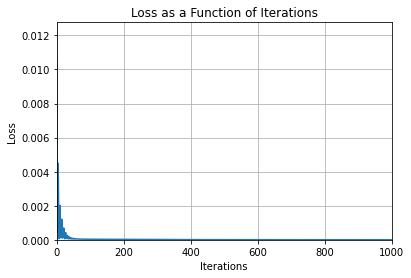

In [179]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(loss_vec)), loss_vec)
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Loss as a Function of Iterations')
ax.set_xlim((0, max_it))
ax.set_ylim((0, max(loss_vec) * 1.2))
plt.grid()
plt.show()

Maybe learn over a random subset of the basis? How to know when finished?